In [1]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py
adjust_plot_scale(0.4)

In [3]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/FED/cocaine_sentencing_2021/fed_equal_act_2021_model_inputs.yaml"
)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3124/3124 [00:00<00:00, 6337.76rows/s]
crime_type         compartment  outflow_to
crack_1600_other   pretrial     prison        79.020979
crack_160_other    pretrial     prison        60.305344
crack_280_other    pretrial     prison        49.295775
crack_5000_other   pretrial     prison        68.382353
crack_500_other    pretrial     prison        53.278689
powder_280_other   pretrial     prison        73.880597
powder_4000_other  pretrial     prison        77.600000
powder_400_other   pretrial     prison        76.978417
Name: percent_missing, dtype: float64
Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5366/5366 [00:00<00:00, 9464.59rows/s]


initialization time:  114.42566919326782


simulation_time:  67.7381317615509


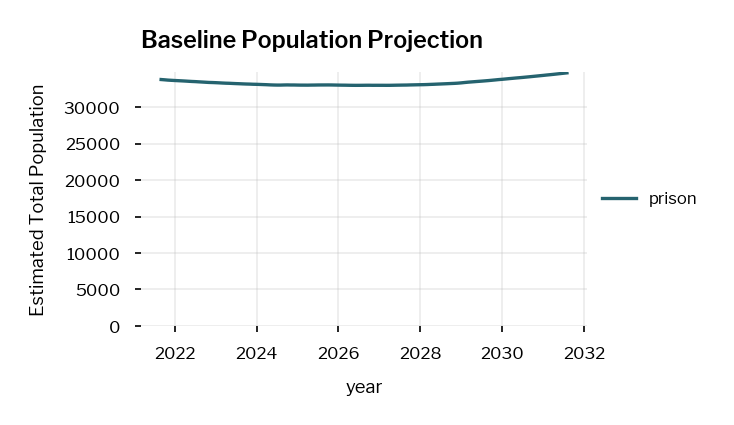

In [4]:
policy_sim.simulate_baseline(["prison"])
add_legend()

In [5]:
data_inputs = policy_sim.initializer.get_data_inputs()
baseline_projection = policy_sim.get_population_simulations()[
    "baseline_projections"
].get_population_projections()
baseline_outflows = policy_sim.get_population_simulations()[
    "baseline_projections"
].get_outflows()
baseline_outflows.head()

total_population compartment simulation_group
outflow_to time_step                                               
release    -241               0.000000      prison     crack_0_drug
           -240               0.000000      prison     crack_0_drug
           -239               0.000000      prison     crack_0_drug
           -238               0.424267      prison     crack_0_drug
           -237               0.634029      prison     crack_0_drug

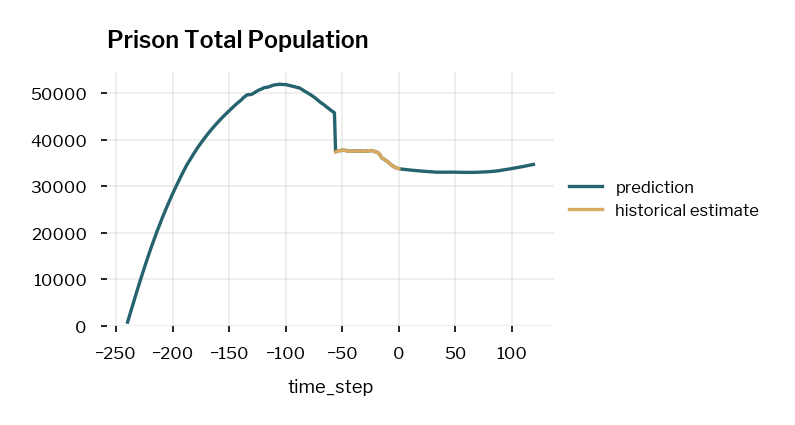

In [6]:
total_population = data_inputs.total_population_data
for compartment, df in baseline_projection.groupby("compartment"):
    if "release" in compartment:
        continue
    plt.figure()
    df.groupby(["time_step"])["total_population"].sum().plot(label="prediction")

    compartment_pop = total_population[total_population["compartment"] == compartment]
    compartment_pop.groupby(["time_step"])["total_population"].sum().plot(
        label="historical estimate"
    )

    add_legend()
    plt.title(f"{compartment.title()} Total Population")
    plt.ylim([0, None])

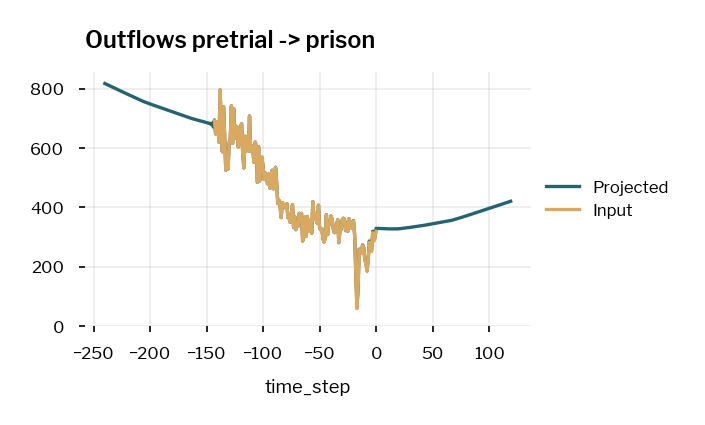

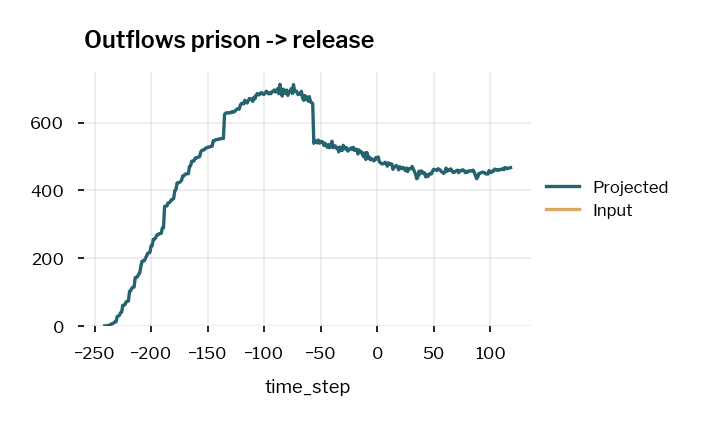

In [7]:
outflows = data_inputs.outflows_data
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if "release" in compartment:
        continue
    plt.figure()
    ax = df.groupby("time_step")["total_population"].sum().plot(label="Projected")

    outflows[
        (outflows["compartment"] == compartment)
        & (outflows["outflow_to"] == outflow_to)
    ].groupby("time_step")["total_population"].sum().plot(ax=ax, label="Input")

    add_legend()
    plt.title(f"Outflows {compartment} -> {outflow_to}")
    plt.ylim([0, None])

In [8]:
# Simulate EQUAL Act
baseline_transitions = data_inputs.transitions_data[
    [
        "compartment_duration",
        "compartment",
        "outflow_to",
        "total_population",
        "crime_type",
    ]
]
reclassified_to_no_mm = ["crack_28", "crack_160", "crack_280"]
reclassified_to_5_mm = ["crack_500", "crack_1600"]

prison_transitions = baseline_transitions[
    baseline_transitions["compartment"] == "prison"
]

df_list = []
for crime_category in ["drug", "other"]:
    for crime_type in reclassified_to_no_mm:
        #     new_transitions = prison_transitions[prison_transitions["crime_type"] == f"crack_0"].copy()
        new_transitions = prison_transitions[
            prison_transitions["crime_type"] == f"crack_0_{crime_category}"
        ].copy()
        new_transitions["crime_type"] = f"{crime_type}_{crime_category}"
        df_list.append(new_transitions)

    for crime_type in reclassified_to_5_mm:
        #     new_transitions = prison_transitions[prison_transitions["crime_type"] == f"crack_28"].copy()
        new_transitions = prison_transitions[
            prison_transitions["crime_type"] == f"crack_28_{crime_category}"
        ].copy()
        new_transitions["crime_type"] = f"{crime_type}_{crime_category}"
        df_list.append(new_transitions)

equal_policy_transitions = pd.concat(df_list)
equal_policy_transitions.head()

,compartment_duration,compartment,outflow_to,total_population,crime_type
3066,85.0,prison,release,0.018569,crack_28_drug
3240,15.0,prison,release,0.006008,crack_28_drug
3241,25.0,prison,release,0.006008,crack_28_drug
3242,68.0,prison,release,0.006008,crack_28_drug
3243,117.0,prison,release,0.006008,crack_28_drug


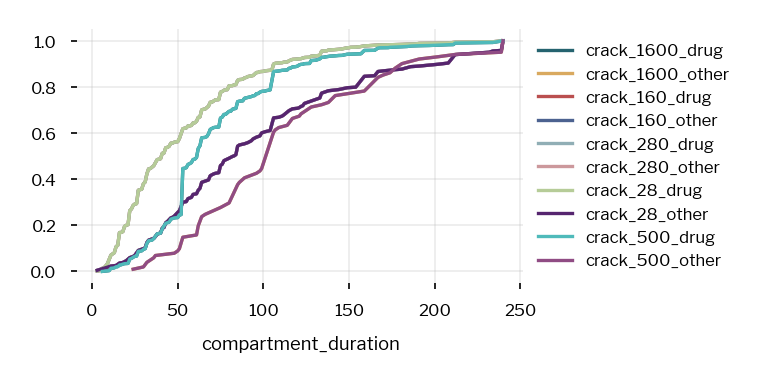

In [35]:
for crime_type, group in equal_policy_transitions.groupby("crime_type"):
    group.set_index("compartment_duration").sort_index()[
        "total_population"
    ].cumsum().plot(label=crime_type)
add_legend()

In [42]:
from typing import Tuple


def add_bottom_legend(
    ncol=5, title: Optional[str] = None, bbox: Tuple[float, float] = (0.5, -0.15)
):
    plt.legend(loc="upper center", bbox_to_anchor=bbox, title=title, ncol=ncol)

In [57]:
equal_act_example["total_population"].cumsum()

compartment_duration
0.283126     0.002185
0.377501     0.003277
0.471876     0.005461
0.566251     0.014200
0.660627     0.016384
0.755002     0.024577
0.849377     0.034407
1.038128     0.070999
1.132503     0.076461
1.226878     0.081376
1.321253     0.107591
1.415629     0.113599
1.510004     0.168760
1.604379     0.169306
1.698754     0.173129
1.793129     0.196068
1.887505     0.200437
1.981880     0.203168
2.076255     0.263790
2.170630     0.270890
2.265006     0.286729
2.359381     0.292736
2.453756     0.293829
2.548131     0.352267
2.736882     0.356636
2.831257     0.380666
2.925632     0.387766
3.020008     0.422720
3.114383     0.444566
3.208758     0.446204
3.397508     0.458220
3.491884     0.471873
3.586259     0.484981
3.680634     0.486619
3.775009     0.488804
3.869385     0.512288
3.963760     0.513381
4.058135     0.536319
4.152510     0.537957
4.246886     0.542873
4.341261     0.555980
4.435636     0.556526
4.530011     0.560350
4.624387     0.561988
4.718762   

In [60]:
baseline_example["total_population"].cumsum()

compartment_duration
0.566251     0.000487
0.755002     0.001947
0.849377     0.002921
0.943752     0.003895
1.038128     0.014119
1.132503     0.014606
1.226878     0.016066
1.321253     0.020448
1.415629     0.020935
1.510004     0.028724
1.604379     0.029211
1.698754     0.032132
1.793129     0.034080
1.887505     0.034567
1.981880     0.035054
2.076255     0.054041
2.170630     0.056962
2.265006     0.061831
2.359381     0.065725
2.453756     0.066699
2.548131     0.087634
2.642507     0.088608
2.736882     0.089581
2.831257     0.095910
2.925632     0.098832
3.020008     0.121714
3.114383     0.133398
3.208758     0.134859
3.303133     0.136319
3.397508     0.142648
3.491884     0.152386
3.586259     0.163096
3.680634     0.164557
3.775009     0.166018
3.869385     0.185005
4.058135     0.208861
4.246886     0.214216
4.341261     0.226874
4.530011     0.232230
4.624387     0.233204
4.718762     0.233690
4.813137     0.245862
4.907512     0.246349
5.001888     0.446446
5.096263   

Text(0.0, 1.0, 'Cumulative Prison Sentence Length\nCrack Cocaine Sentences for 28-499g')

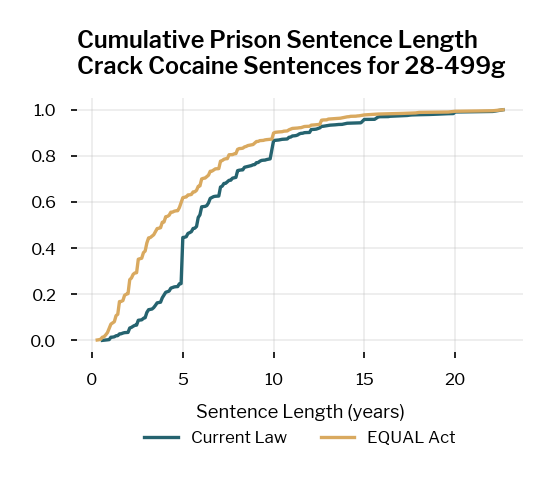

In [79]:
baseline_example = (
    prison_transitions[prison_transitions["crime_type"] == "crack_28_drug"]
    .set_index("compartment_duration")
    .sort_index()
)
baseline_example.index /= 0.883 * 12
baseline_example["total_population"].cumsum().plot(label="Current Law")

equal_act_example = (
    equal_policy_transitions[equal_policy_transitions["crime_type"] == "crack_28_drug"]
    .set_index("compartment_duration")
    .sort_index()
)
equal_act_example.index /= 0.883 * 12
equal_act_example["total_population"].cumsum().plot(label="EQUAL Act")

add_bottom_legend(bbox=(0.5, -0.25))
plt.xlabel("Sentence Length (years)")
plt.title("Cumulative Prison Sentence Length\nCrack Cocaine Sentences for 28-499g")

<AxesSubplot:xlabel='time_step'>

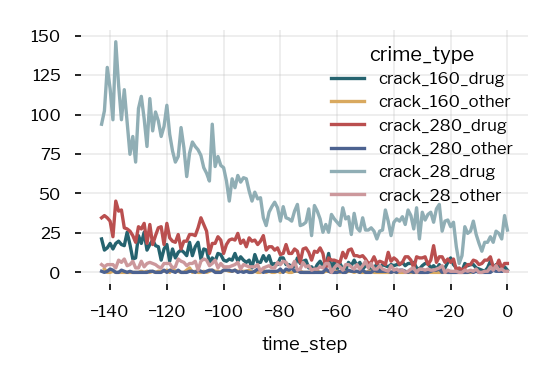

In [69]:
outflows[
    outflows["crime_type"].isin(
        [
            "crack_28_drug",
            "crack_28_other",
            "crack_160_drug",
            "crack_160_other",
            "crack_280_drug",
            "crack_280_other",
        ]
    )
].set_index(["time_step", "crime_type"]).sort_index()["total_population"].unstack(
    "crime_type"
).plot()

In [74]:
outflows[
    outflows["crime_type"].isin(
        [
            "crack_28_drug",
            "crack_28_other",
            "crack_160_drug",
            "crack_160_other",
            "crack_280_drug",
            "crack_280_other",
        ]
    )
].groupby("time_step").sum()["total_population"].tail(36).mean()

39.86938888888889

In [75]:
outflows[outflows["crime_type"].isin(["crack_28_drug", "crack_28_other",])].groupby(
    "time_step"
).sum()["total_population"].tail(36).mean()

29.02444444444444

In [78]:
outflows[
    outflows["crime_type"].isin(
        [
            "crack_500_drug",
            "crack_500_other",
            "crack_1600_drug",
            "crack_1600_other",
        ]
    )
].groupby("time_step").sum()["total_population"].tail(36).mean()

4.804722222222222

In [62]:
outflows["crime_type"].unique()

array(['crack_0_drug', 'crack_0_other', 'crack_1600_drug',
       'crack_1600_other', 'crack_160_drug', 'crack_160_other',
       'crack_280_drug', 'crack_280_other', 'crack_28_drug',
       'crack_28_other', 'crack_5000_drug', 'crack_5000_other',
       'crack_500_drug', 'crack_500_other', 'powder_0_drug',
       'powder_0_other', 'powder_280_drug', 'powder_280_other',
       'powder_28_drug', 'powder_28_other', 'powder_4000_drug',
       'powder_4000_other', 'powder_400_drug', 'powder_400_other',
       'powder_5000_drug', 'powder_5000_other', 'powder_500_drug',
       'powder_500_other'], dtype=object)

In [10]:
# Simulate policy starting July 1, 2022
policy_ts = 10

# Policy function
def replace_sentencing_matrix(policy_transitions, simulation_group, retroactive=True):
    subset_policy_transitions = policy_transitions[
        policy_transitions["crime_type"] == simulation_group
    ]
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=subset_policy_transitions,
        retroactive=retroactive,
    )


policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(equal_policy_transitions, crime_type),
        spark_compartment="prison",
        sub_population={"crime_type": crime_type},
        policy_ts=policy_ts,
        apply_retroactive=True,
    )
    for crime_type in equal_policy_transitions["crime_type"].unique()
]

initialization time:  130.82419872283936
initialization time:  132.64287424087524
simulation_time:  76.8880569934845


simulation_time:  78.56100702285767
38177.96028054346


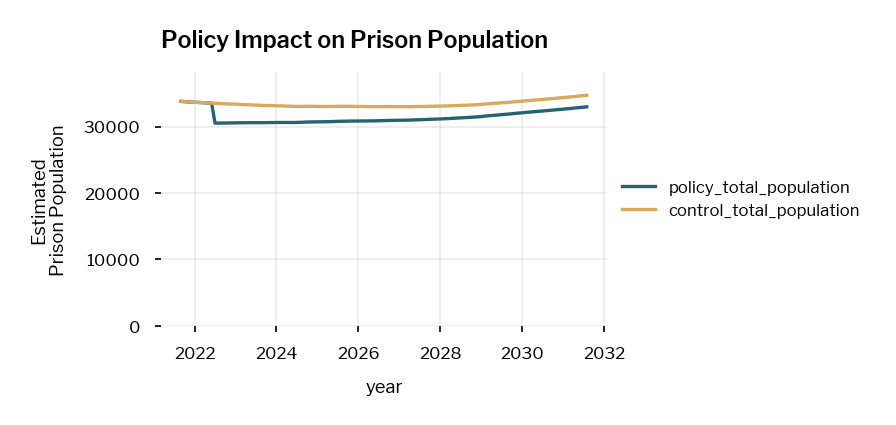

In [11]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [12]:
policy_results.groupby(["compartment", "year"]).sum()[
    ["policy_total_population", "control_total_population"]
].loc["prison"]

,policy_total_population,control_total_population
year,,
2021.666667,33792.000000,33792.000000
2021.750000,33755.182282,33755.182282
2021.833333,33713.440830,33713.440830
2021.916667,33684.776377,33684.776377
2022.000000,33658.556002,33658.556002
2022.083333,33634.979647,33634.979647
2022.166667,33610.701470,33610.701470
2022.250000,33585.101191,33585.101191
2022.333333,33554.869288,33554.869288


In [13]:
policy_results[policy_results["compartment"] == "prison"].set_index(
    "simulation_group", append=True
)

,,compartment,policy_total_population,control_total_population
year,simulation_group,,,
2021.666667,crack_0_drug,prison,2581.000000,2581.000000
2021.750000,crack_0_drug,prison,2578.645462,2578.645462
2021.833333,crack_0_drug,prison,2575.697998,2575.697998
2021.916667,crack_0_drug,prison,2572.000582,2572.000582
2022.000000,crack_0_drug,prison,2568.023561,2568.023561
...,...,...,...,...
2031.250000,powder_500_other,prison,284.630379,284.630379
2031.333333,powder_500_other,prison,283.108288,283.108288
2031.416667,powder_500_other,prison,281.943789,281.943789


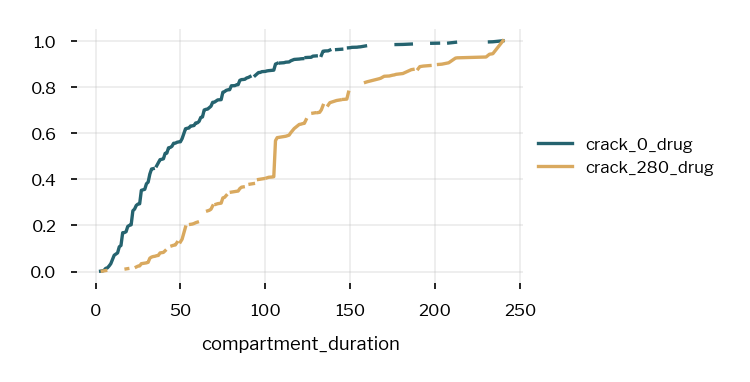

In [15]:
baseline_transitions[
    (baseline_transitions["compartment"] == "prison")
    & (baseline_transitions["crime_type"].isin(["crack_280_drug", "crack_0_drug"]))
].set_index(["compartment_duration", "crime_type"]).unstack("crime_type").sort_index()[
    "total_population"
].cumsum().plot()
add_legend()

<AxesSubplot:xlabel='year'>

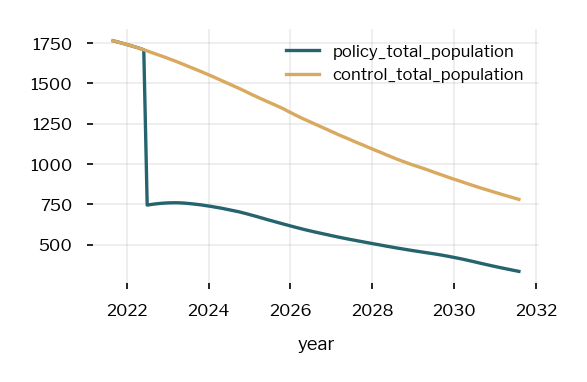

In [16]:
policy_results[
    (policy_results["compartment"] == "prison")
    & (policy_results["simulation_group"] == "crack_280_drug")
][["policy_total_population", "control_total_population"]].plot()

Text(0, 0.5, 'Percent Population Difference')

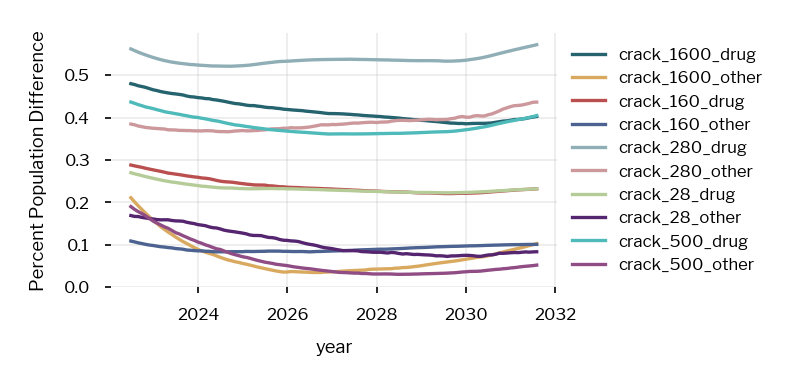

In [17]:
policy_results["population_difference"] = (
    policy_results["control_total_population"]
    - policy_results["policy_total_population"]
) / policy_results["control_total_population"]
policy_results[
    (policy_results["compartment"] == "prison")
    & (policy_results["population_difference"] > 0)
].set_index("simulation_group", append=True)["population_difference"].unstack(
    "simulation_group"
).plot()
add_legend()
plt.ylim([0, None])
plt.ylabel("Percent Population Difference")

In [18]:
simulation_tag = "fed_equal_2021"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed fr

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]


In [19]:
# Simulate SMART Act
baseline_transitions = data_inputs.transitions_data[
    [
        "compartment_duration",
        "compartment",
        "outflow_to",
        "total_population",
        "crime_type",
    ]
]
reclassified_to_no_mm = ["crack_28"]
reclassified_to_5_mm = ["crack_280", "crack_500"]

powder_reclassified_to_5_mm = ["powder_400"]
powder_reclassified_to_10_mm = ["powder_4000"]

prison_transitions = baseline_transitions[
    baseline_transitions["compartment"] == "prison"
]

df_list = []
for primary_crime_category in ["drug", "other"]:
    for crime_type in reclassified_to_no_mm:
        new_transitions = prison_transitions[
            prison_transitions["crime_type"] == f"crack_0_{primary_crime_category}"
        ].copy()
        new_transitions["crime_type"] = f"{crime_type}_{primary_crime_category}"
        df_list.append(new_transitions)

    for crime_type in reclassified_to_5_mm:
        new_transitions = prison_transitions[
            prison_transitions["crime_type"] == f"crack_28_{primary_crime_category}"
        ].copy()
        new_transitions["crime_type"] = f"{crime_type}_{primary_crime_category}"
        df_list.append(new_transitions)

    for crime_type in powder_reclassified_to_5_mm:
        new_transitions = prison_transitions[
            prison_transitions["crime_type"] == f"powder_500_{primary_crime_category}"
        ].copy()
        new_transitions["crime_type"] = f"{crime_type}_{primary_crime_category}"
        df_list.append(new_transitions)

    for crime_type in powder_reclassified_to_10_mm:
        new_transitions = prison_transitions[
            prison_transitions["crime_type"] == f"powder_5000_{primary_crime_category}"
        ].copy()
        new_transitions["crime_type"] = f"{crime_type}_{primary_crime_category}"
        df_list.append(new_transitions)

smart_policy_transitions = pd.concat(df_list)
smart_policy_transitions.head()

,compartment_duration,compartment,outflow_to,total_population,crime_type
3066,85.0,prison,release,0.018569,crack_28_drug
3240,15.0,prison,release,0.006008,crack_28_drug
3241,25.0,prison,release,0.006008,crack_28_drug
3242,68.0,prison,release,0.006008,crack_28_drug
3243,117.0,prison,release,0.006008,crack_28_drug


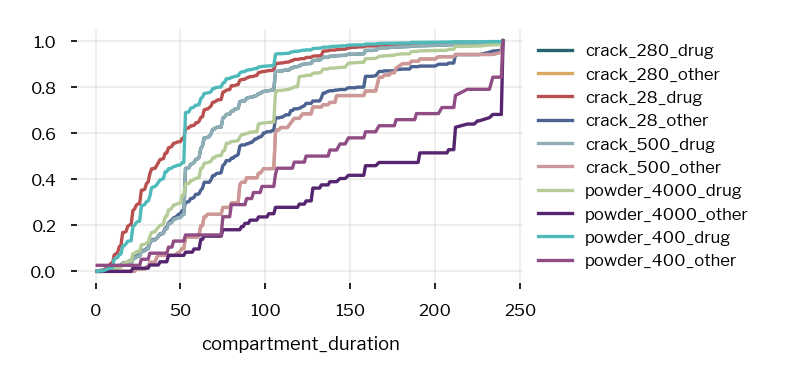

In [20]:
smart_policy_transitions.groupby(["compartment_duration", "crime_type"])[
    "total_population"
].sum().unstack("crime_type").fillna(0).cumsum().plot()
add_legend()

In [21]:
policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(smart_policy_transitions, crime_type),
        spark_compartment="prison",
        sub_population={"crime_type": crime_type},
        policy_ts=policy_ts,
        apply_retroactive=True,
    )
    for crime_type in smart_policy_transitions["crime_type"].unique()
]

initialization time:  128.05266284942627
initialization time:  124.5647349357605
simulation_time:  77.94659519195557


simulation_time:  73.0489673614502
38177.96028054346


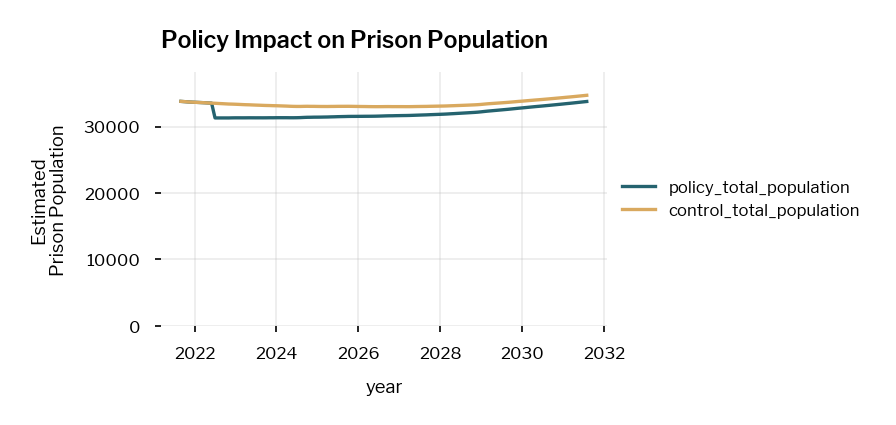

In [22]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [23]:
simulation_tag = "fed_smart_act"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed fr

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]


In [24]:
prison_transitions.head()

,compartment_duration,compartment,outflow_to,total_population,crime_type
2688,1.0,prison,release,0.001192,crack_280_drug
2689,4.0,prison,release,0.001192,crack_280_drug
2690,5.0,prison,release,0.001192,crack_280_drug
2691,6.0,prison,release,0.001192,crack_280_drug
2692,19.0,prison,release,0.001192,crack_280_drug


In [30]:
# Simulate SMART Act with less retroactivity

retroactive_rate = 0.2
# retroactive_rate = 0.6

baseline_transitions = data_inputs.transitions_data[
    [
        "compartment_duration",
        "compartment",
        "outflow_to",
        "total_population",
        "crime_type",
    ]
]
reclassified_to_no_mm = ["crack_28"]
reclassified_to_5_mm = ["crack_280", "crack_500"]

# These are not retroactively increased
# powder_reclassified_to_5_mm = ["powder_400"]
# powder_reclassified_to_10_mm = ["powder_4000"]

prison_transitions = baseline_transitions[
    baseline_transitions["compartment"] == "prison"
]


def get_transitions(crime_type):
    return prison_transitions[prison_transitions["crime_type"] == crime_type].copy()


def apply_some_retroactive(crime_type, new_classification, retroactive_rate):
    new_transitions = get_transitions(new_classification)
    new_transitions["total_population"] *= retroactive_rate
    new_transitions["crime_type"] = crime_type
    old_transitions = get_transitions(crime_type)
    old_transitions["total_population"] *= 1 - retroactive_rate
    new_transitions = pd.concat([new_transitions, old_transitions])
    new_transitions = (
        new_transitions.groupby(
            ["compartment_duration", "compartment", "outflow_to", "crime_type"]
        )
        .sum()["total_population"]
        .reset_index(drop=False)
    )
    return new_transitions


df_list = []
for primary_crime_category in ["drug", "other"]:
    for crime_type in reclassified_to_no_mm:
        new_transitions = apply_some_retroactive(
            f"{crime_type}_{primary_crime_category}",
            f"crack_0_{primary_crime_category}",
            retroactive_rate,
        )
        df_list.append(new_transitions)

    for crime_type in reclassified_to_5_mm:
        new_transitions = apply_some_retroactive(
            f"{crime_type}_{primary_crime_category}",
            f"crack_28_{primary_crime_category}",
            retroactive_rate,
        )
        df_list.append(new_transitions)

smart_policy_transitions_less_retroactive = pd.concat(df_list)
smart_policy_transitions_less_retroactive.head()

,compartment_duration,compartment,outflow_to,crime_type,total_population
0,3.0,prison,release,crack_28_drug,0.000437
1,4.0,prison,release,crack_28_drug,0.000218
2,5.0,prison,release,crack_28_drug,0.000437
3,6.0,prison,release,crack_28_drug,0.002137
4,7.0,prison,release,crack_28_drug,0.000437


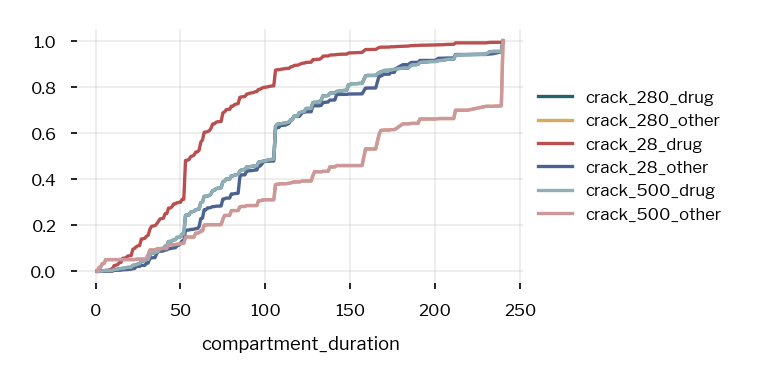

In [31]:
smart_policy_transitions_less_retroactive.groupby(
    ["compartment_duration", "crime_type"]
)["total_population"].sum().unstack("crime_type").fillna(0).cumsum().plot()
add_legend()

In [32]:
policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(
            smart_policy_transitions_less_retroactive, crime_type, retroactive=True
        ),
        spark_compartment="prison",
        sub_population={"crime_type": crime_type},
        policy_ts=policy_ts,
        apply_retroactive=True,
    )
    for crime_type in smart_policy_transitions_less_retroactive["crime_type"].unique()
] + [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(
            smart_policy_transitions, crime_type, retroactive=False
        ),
        spark_compartment="prison",
        sub_population={"crime_type": crime_type},
        policy_ts=policy_ts,
        apply_retroactive=False,
    )
    for crime_type in smart_policy_transitions["crime_type"].unique()
]

initialization time:  146.94382882118225
initialization time:  146.74200439453125
simulation_time:  86.06994318962097


simulation_time:  85.26648712158203
38177.96028054346


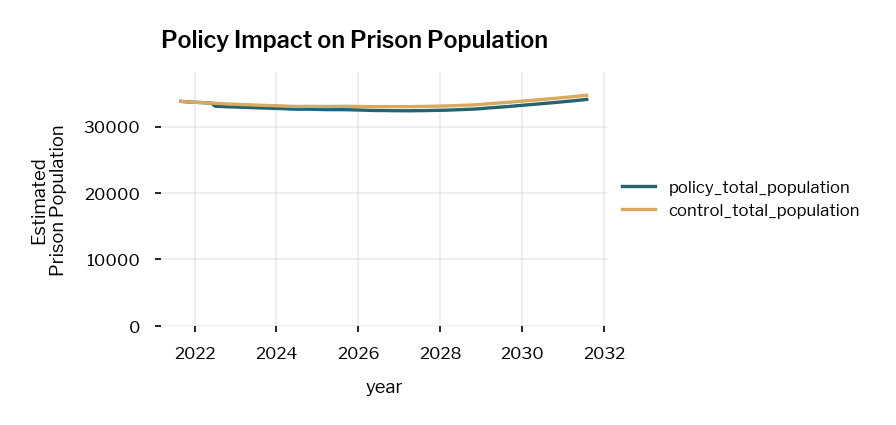

In [33]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [29]:
simulation_tag = "fed_smart_act_60pct"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed fr

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed fr

In [34]:
simulation_tag = "fed_smart_act_20pct"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed fr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


In [56]:
# Simulate Equal Enforcement Act
baseline_transitions = data_inputs.transitions_data[
    [
        "compartment_duration",
        "compartment",
        "outflow_to",
        "total_population",
        "crime_type",
    ]
]

powder_reclassified_to_5_mm = ["powder_28"]
powder_reclassified_to_10_mm = ["powder_280", "powder_400", "powder_500", "powder_4000"]

df_list = []

for crime_type in powder_reclassified_to_5_mm:
    new_transitions = baseline_transitions[
        baseline_transitions["crime_type"] == "powder_500"
    ].copy()
    new_transitions["crime_type"] = crime_type
    df_list.append(new_transitions)

for crime_type in powder_reclassified_to_10_mm:
    new_transitions = baseline_transitions[
        baseline_transitions["crime_type"] == "powder_5000"
    ].copy()
    new_transitions["crime_type"] = crime_type
    df_list.append(new_transitions)

equal_enforcement_policy_transitions = pd.concat(df_list)
equal_enforcement_policy_transitions.head()

,compartment_duration,compartment,outflow_to,total_population,crime_type
11,34.0,release,prison,0.002770,powder_28
39,12.0,release,prison,0.002776,powder_28
53,24.0,release,prison,0.002791,powder_28
88,10.0,release,prison,0.002775,powder_28
123,21.0,release,prison,0.002787,powder_28


In [57]:
policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(
            equal_enforcement_policy_transitions, crime_type, retroactive=False
        ),
        spark_compartment="prison",
        sub_population={"crime_type": crime_type},
        policy_ts=policy_ts,
        apply_retroactive=False,
    )
    for crime_type in euqal_enforcement_policy_transitions["crime_type"].unique()
]

initialization time:  56.630656003952026
initialization time:  58.260298013687134
simulation_time:  33.664715051651


simulation_time:  37.927042722702026
38612.200000000004


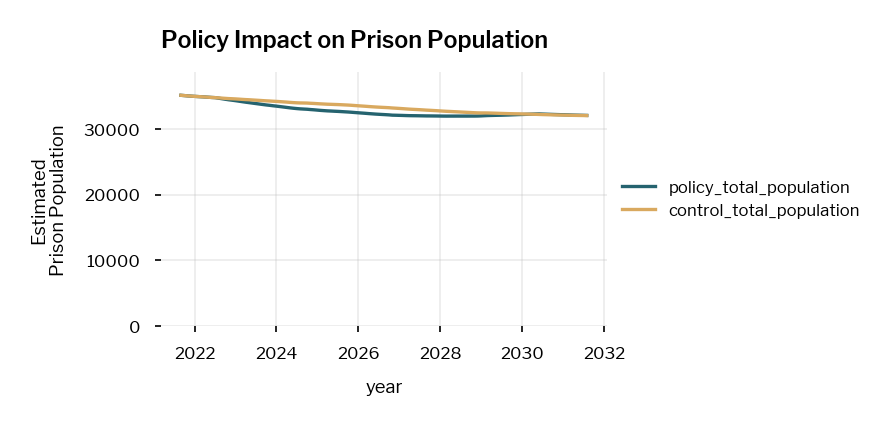

In [58]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [60]:
simulation_tag = "fed_equal_enforcement_act"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
/Users/justine/pulse-data/recidiviz/calculator/modeling/population_projection/notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:337: FutureWarning: The frame.append method is deprecated and will be removed fr

Text(0.0, 1.0, '10 Year MM LOS for Powder Cocaine')

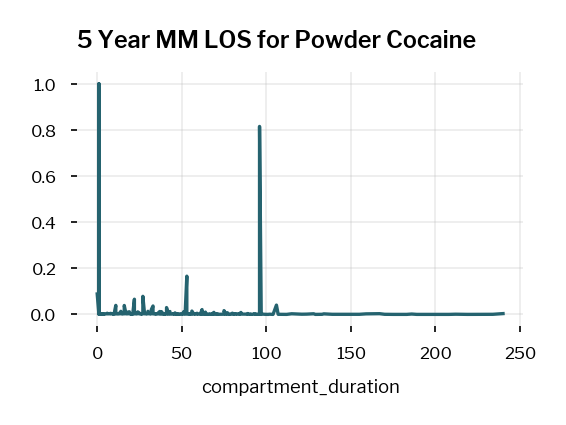

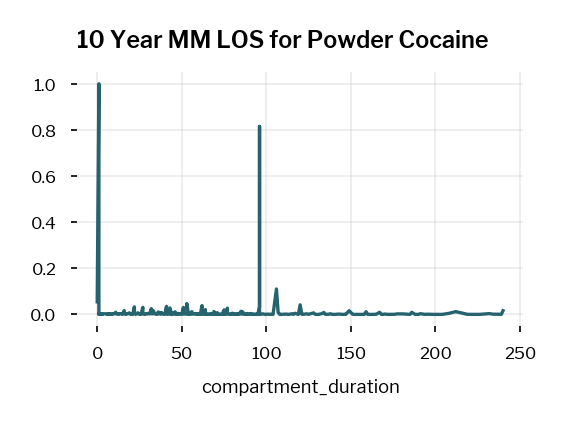

In [66]:
baseline_transitions[baseline_transitions["crime_type"] == "powder_500"].set_index(
    "compartment_duration"
).sort_index()["total_population"].plot()
plt.title("5 Year MM LOS for Powder Cocaine")
plt.figure()
baseline_transitions[baseline_transitions["crime_type"] == "powder_5000"].set_index(
    "compartment_duration"
).sort_index()["total_population"].plot()
plt.title("10 Year MM LOS for Powder Cocaine")